In [0]:
# Using google colab - this first step is for loading in the data from my personal Drive

# Login with google credentials

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Handle errors from too many requests

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

# The ID for my personal Drive folder is 1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx
# I am now listing the ID numbers for the files in this folder to find the data files

#file_list = drive.ListFile({'q': "'1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx' in parents and trashed=false"}).GetList()
#for file1 in file_list:
#  print('title: %s, id: %s' % (file1['title'], file1['id']))

# Data ID: 1F2KojI0d-ZnN8ssQFUWSyZA8I0mAgMEf

# Now that I have the ID files, load the files

data_downloaded = drive.CreateFile({'id': '1F2KojI0d-ZnN8ssQFUWSyZA8I0mAgMEf'})
data_downloaded.GetContentFile('Full.csv')

In [0]:
# Load the data into pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
data = pd.read_csv('Full.csv',low_memory=False, lineterminator='\n')

In [92]:
print(data.isnull().values.any())

# No nulls after import

False


In [93]:
data.head(3)

,Year_sold,PARCEL,SequenceNum,SaleDate,SalePrice,PrPerSqFt,p_Cat,RecordingDate,INSPECTION,CLASS,STORIES,ROOMS,QUALITY,WALLS,ROOF,HEAT,COOL,BATHFIXTUR,PATIO,PATIONUMBE,CONDITION,SQFT,YEAR,GARAGE,GARAGECAPA,POOLAREA,MAIN,CONTROL,ACTUAL,LASTACTION,GISACRES,LON,LAT,ZIP,NonPrimary,PrimaryRes,Rental,JointTenancyDeed,WarrantyDeed,FinancingCash,isSolar,GoodSale,BSOutOfState,SaleUnderDuress,NoAssessmentRole,BSRelatedorCorporate,SaleGovt,isBuyerSellerRelated,isPersonalProperty,isPartialInterest
0,2019,401554180,20191960498,201906,49000,61.790668,6,43661,Apr 1 1996 12:00AM,2,1.0,4,1,0,2,6,2,3,1,0,1,793,1951,9,0,0,51267,51267,49985,19970605,0.155122,-112.859266,32.377690,17517,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0
1,2019,401554100,20190300552,201901,50500,63.682219,6,43495,Mar 1 1996 12:00AM,2,1.0,4,1,0,2,6,1,3,1,0,1,793,1951,9,0,0,53101,53101,51773,20061129,0.149963,-112.861439,32.378276,85321,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
2,2019,401553650,20191970632,201907,58000,63.112078,6,43662,Apr 1 1996 12:00AM,2,1.0,5,1,0,2,6,1,3,0,1,1,919,1953,3,1,0,60223,60223,58717,19970605,0.158440,-112.859970,32.379842,85321,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [0]:
import seaborn as sn
corrMat = data.corr()

#plt.figure(figsize=(30,15))
#sn.heatmap(corrMat, annot=True)

# SalesPrice correlates heavily with CLASS, PrPerSqFt, BATHFIXTUR, MAIN, CONTROL, ACTUAL

# Years_sold, SequenceNum, SalesDate are all the same

# MAIN, CONTROL, ACTUAL are all about the same

In [0]:
# Feature Engineering

## Years_sold, SequenceNum, SalesDate and RecordingDate all contain basically the same info. Of them, RecordingDate most closely tracks SalesPrice.

data = data.drop(columns=['Year_sold', 'SequenceNum'], axis=1)

## Main, Control, Actual are all tax assessments. Let's average them and use thart instead.

data['TaxEval'] = (data['MAIN'] + data['CONTROL'] + data['ACTUAL'] ) / 3

data['diff'] = data['SalePrice'] - data['TaxEval']

data = data.drop(columns=['MAIN', 'CONTROL', 'ACTUAL'], axis=1)

## PrPerSqFt is just SalesPrice / Sqft. There's no reason to include that along with sales price.

## PARCEL is an ID number - don't need.
data = data.drop(columns=['PARCEL', 'INSPECTION'], axis=1)

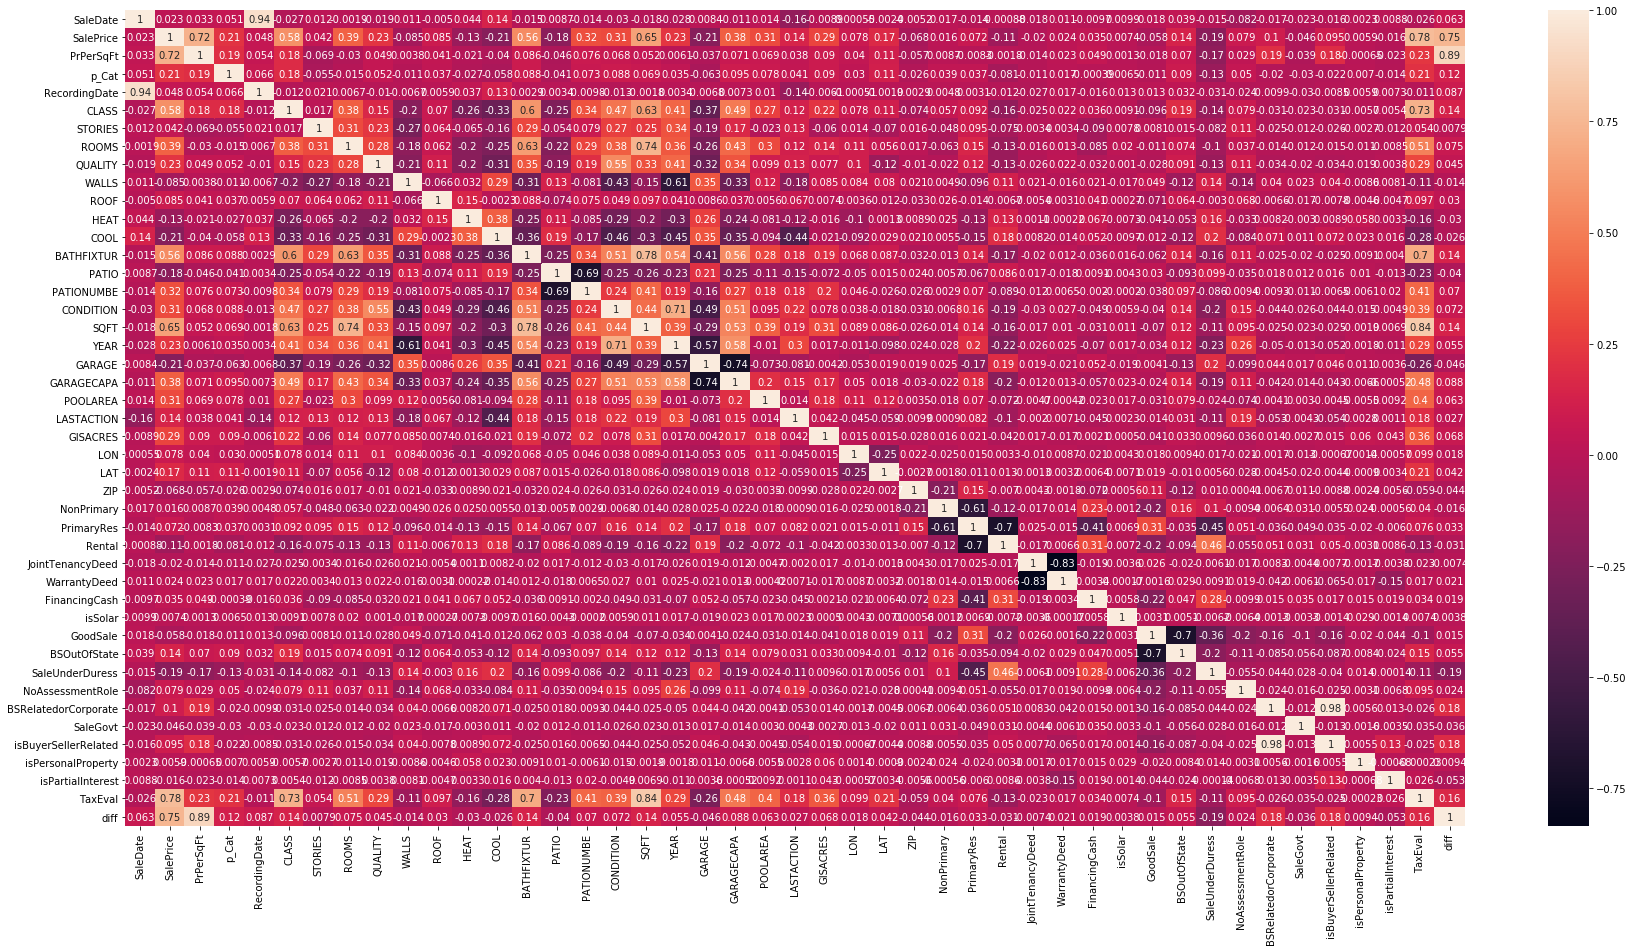

In [96]:
features = list(data.columns.values.tolist())

corrMat = data[features].corr()

plt.figure(figsize=(30,15))
sn.heatmap(corrMat, annot=True)

# Now remove features we can't use in the model

features.remove('diff')
features.remove('PrPerSqFt')
features.remove('TaxEval')

In [118]:
# Normalize all data. That way my weights will be my importances

normalized_df=(data-data.min())/(data.max()-data.min())

print((normalized_df['SalePrice'] - normalized_df['TaxEval']).mean())

# train test split

data_copy = normalized_df.copy()
trainData = data_copy.sample(frac=0.8, random_state=0)
testData = data_copy.drop(trainData.index)

X_train = trainData[features].to_numpy().astype(float)
y_train = (trainData['diff']).to_numpy().reshape(len(trainData),1).astype(float)

X_test = testData[features].to_numpy().astype(float)
y_test = (testData['diff']).to_numpy().reshape(len(testData),1).astype(float)

-0.04555994695631326


In [0]:
class OrdinaryLeastSquares():
  def _init_(self):
    self.coefficients = []

  def _reshape_x(self,X):
    return X.reshape(-1, 1)

  def _concatenate_ones(self, X):
    ones = np.ones(shape = X.shape[0]).reshape(-1,1)
    return np.concatenate((ones, X), 1)

  def fit(self, X, y):

    if len(X.shape) == 1: X = self._reshape_x(X)

    X = self._concatenate_ones(X)

    self.coefficients = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)

  def predict_one(self, y):
    w0 = self.coefficients[0]
    other_gammas = self.coefficients[1:]
    prediction = w0

    for xi, wi in zip(y, other_gammas):
      prediction = prediction + (wi * xi)
    
    return prediction

  def predict(self, y):

    y_preds = []

    for row in y:
      y_preds.append(self.predict_one(row))

    return y_preds

  def get_importance(self):

    return self.coefficients

def rmse(y, y_hat):

  #combined rmse value
  rss=((y-y_hat)**2).sum()
  mse=np.mean((y-y_hat)**2)
  rmse = np.sqrt(mse)

  return rmse

def getImportanceTable(ols, features):

  weights_array = ols.get_importance().astype(float).tolist()
  weights_array = [item for sublist in weights_array for item in sublist]
  weights_array = weights_array[1:]
  weights_sum = sum(list(map(abs, weights_array)))

  weights_array[:] = [x / weights_sum for x in weights_array]

  importances = list(zip(features, weights_array))
  importances = sorted(importances, key=lambda x : abs(x[1]), reverse=True)

  num = np.array(importances)
  reshaped = num.reshape(len(features),2)
  print(pd.DataFrame(reshaped, columns=['Feature','Importance']))

0.8821828236467271
0.036954835707755804
0.3094048175858326


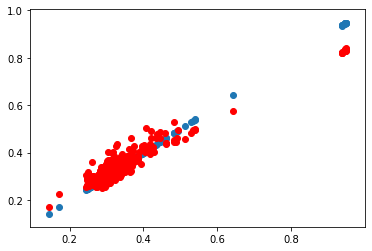

In [99]:
ols = OrdinaryLeastSquares()

ols.fit(X_train,y_train)
y_hat = ols.predict(X_test)

y_hat = [item for sublist in y_hat for item in sublist]

X_plot = y_test

plt.figure()
plt.scatter(X_plot,y_test)
plt.scatter(X_plot,y_hat, color='#FF0000')

from sklearn.metrics import r2_score

print(r2_score(y_test, y_hat))
print(rmse(y_test, y_hat))
print(np.mean(y_test))

In [100]:
getImportanceTable(ols, features)

                 Feature               Importance
0              SalePrice       0.5238586940004392
1                   SQFT      -0.1610867276052656
2               GISACRES     -0.05052674619527425
3                  CLASS     -0.04235772289352165
4                  ROOMS     0.034389415493254964
5             BATHFIXTUR    -0.017500576640732925
6             PATIONUMBE    -0.015694745631574816
7                    LON    -0.015447626332676292
8                    LAT    -0.013820349792109683
9      isPartialInterest    -0.013443622589129726
10                  YEAR     0.010601727068947926
11               STORIES     0.010408606279021399
12               QUALITY    -0.010342667567723136
13  isBuyerSellerRelated     0.010105126307962632
14    isPersonalProperty     0.007007546973883275
15                 p_Cat    -0.006075370807905544
16              POOLAREA    -0.005340433535388927
17                  HEAT    -0.005206694505206239
18            GARAGECAPA   -0.0050401740872237895


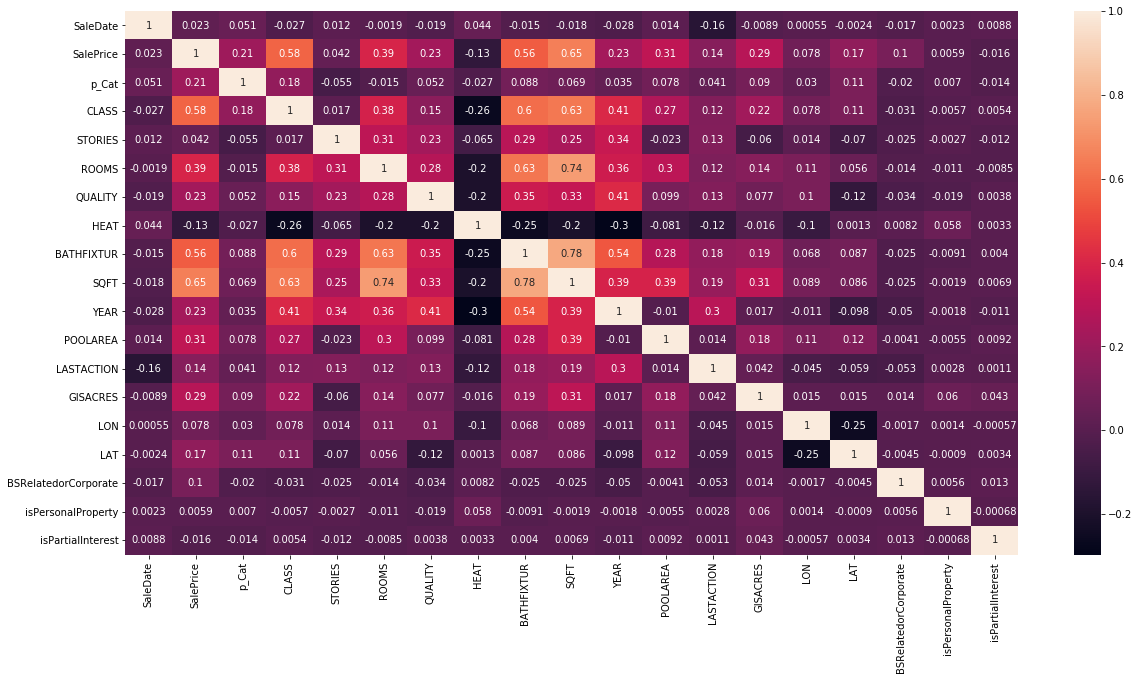

In [101]:
features = list(data.columns.values.tolist())

# Weight coefficients say these features are very unimportant

features.remove('NoAssessmentRole')
features.remove('WarrantyDeed')
features.remove('isSolar')
features.remove('ZIP')
features.remove('FinancingCash')
features.remove('JointTenancyDeed')
features.remove('GARAGE')
features.remove('CONDITION')
features.remove('ROOF')
features.remove('SaleUnderDuress')
features.remove('BSOutOfState')
features.remove('COOL')
features.remove('PATIO')
features.remove('SaleGovt')
features.remove('PrimaryRes')
features.remove('RecordingDate')
features.remove('GARAGECAPA')

# Remove very correlated features based on correlation matrix
features.remove('GoodSale')
features.remove('Rental')
features.remove('NonPrimary')
features.remove('PATIONUMBE')
features.remove('isBuyerSellerRelated')
features.remove('WALLS')

# Stays in because it hurts my model to remove
#features.remove('CLASS')

# Now remove features we can't use in the model

features.remove('diff')
features.remove('PrPerSqFt')
features.remove('TaxEval')

# Print correlation matrix

corrMat = data[features].corr()

plt.figure(figsize=(20,10))
sn.heatmap(corrMat, annot=True)



0.8777362989085593
0.03690838036730064
                 Feature              Importance
0              SalePrice      0.5542740419336928
1                   SQFT     -0.1765944457055261
2               GISACRES    -0.05854365244969522
3                  CLASS    -0.04604063133012461
4                  ROOMS    0.038649221036096894
5             BATHFIXTUR    -0.01979175525196903
6                    LON   -0.014576916416537742
7                    LAT   -0.013937638105724303
8      isPartialInterest   -0.012480076120169279
9                STORIES    0.010666380891096677
10               QUALITY   -0.010618087609952451
11                  YEAR     0.00915728019565712
12                  HEAT   -0.007591248008502165
13                 p_Cat   -0.006445846759644615
14  BSRelatedorCorporate   0.0053432230558870305
15    isPersonalProperty    0.005334874975627119
16              POOLAREA   -0.005137657654759445
17            LASTACTION  -0.0038553440272885756
18              SaleDate   0.0

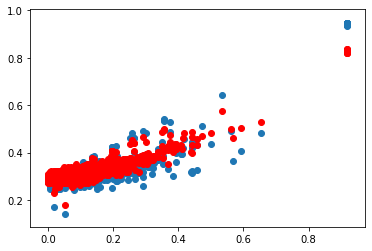

In [114]:
X_train = trainData[features].to_numpy().astype(float)
y_train = (trainData['diff']).to_numpy().reshape(len(trainData),1).astype(float)

X_test = testData[features].to_numpy().astype(float)
y_test = (testData['diff']).to_numpy().reshape(len(testData),1).astype(float)

ols = OrdinaryLeastSquares()

ols.fit(X_train,y_train)
y_hat = ols.predict(X_test)

y_hat = [item for sublist in y_hat for item in sublist]

X_plot = (testData['SalePrice']).to_numpy().reshape(len(testData),1).astype(float)

plt.figure()
plt.scatter(X_plot,y_test)
plt.scatter(X_plot,y_hat, color='#FF0000')

from sklearn.metrics import r2_score

print(r2_score(y_test, y_hat))
print(rmse(y_test, y_hat))

getImportanceTable(ols, features)


In [116]:
print(np.median(y_test))

0.3073582222790861


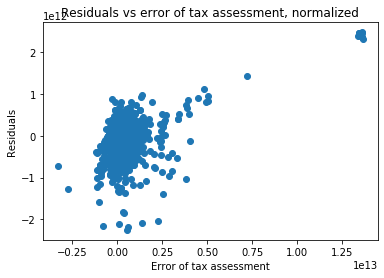

In [111]:
scale_factor = int((max(data['diff']) - min(data['diff'])))

y_test = y_test.reshape(len(y_test),) * scale_factor
y_hat = [x * scale_factor for x in y_hat]
residuals = y_test - y_hat

#print(residuals.shape)
#print(y_test.shape)
#print(scale_factor)
plt.figure()

plt.xlabel('Error of tax assessment')
plt.ylabel('Residuals')
plt.title('Residuals vs error of tax assessment, normalized')

plt.scatter(y_test, residuals)

#print(" RMSE of house value is " +  str(scale_factor * 0.03691012168704651))

0.8777362989087802
169237.7188891875
                 Feature               Importance
0                    LAT      -0.2538650895008694
1      isPartialInterest     -0.17812355698527096
2                  CLASS     -0.13142421472402277
3                    LON     -0.08576271178970861
4   BSRelatedorCorporate      0.07626186629749096
5     isPersonalProperty        0.076142717205788
6                STORIES      0.07611867453217096
7                QUALITY     -0.05051602558156512
8                  ROOMS     0.025073917307846406
9               GISACRES     -0.02197862270553631
10                  HEAT    -0.012038567038466199
11            BATHFIXTUR     -0.01046223985680548
12                  YEAR    0.0010372897411348257
13                 p_Cat   -0.0007863180402079631
14                  SQFT  -0.00027271887741514334
15              POOLAREA   -6.666173327413906e-05
16              SaleDate    6.630765533463487e-05
17             SalePrice    2.383125060784364e-06
18           

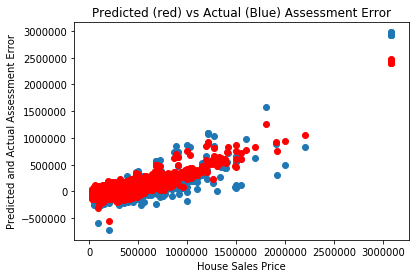

In [104]:
# Normalize all data. That way my weights will be my importances

normalized_df=(data-data.min())/(data.max()-data.min())

# train test split

data_copy = data.copy()
trainData = data_copy.sample(frac=0.8, random_state=0)
testData = data_copy.drop(trainData.index)

X_train = trainData[features].to_numpy().astype(float)
y_train = (trainData['diff']).to_numpy().reshape(len(trainData),1).astype(float)

X_test = testData[features].to_numpy().astype(float)
y_test = (testData['diff']).to_numpy().reshape(len(testData),1).astype(float)

ols = OrdinaryLeastSquares()

ols.fit(X_train,y_train)
y_hat = ols.predict(X_test)

y_hat = [item for sublist in y_hat for item in sublist]

X_plot = (testData['SalePrice']).to_numpy().reshape(len(testData),1).astype(float)

plt.figure()

plt.xlabel('House Sales Price')
plt.ylabel('Predicted and Actual Assessment Error')
plt.title('Predicted (red) vs Actual (Blue) Assessment Error')

plt.scatter(X_plot,y_test)
plt.scatter(X_plot,y_hat, color='#FF0000')

from sklearn.metrics import r2_score

print(r2_score(y_test, y_hat))
print(rmse(y_test, y_hat))

getImportanceTable(ols, features)


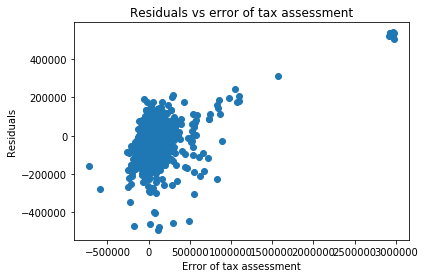

In [105]:
y_test = y_test.reshape(len(y_test),)
residuals = y_test - y_hat

#print(residuals.shape)
#print(y_test.shape)
#print(scale_factor)
plt.figure()

plt.xlabel('Error of tax assessment')
plt.ylabel('Residuals')
plt.title('Residuals vs error of tax assessment')

plt.scatter((y_test), (residuals))

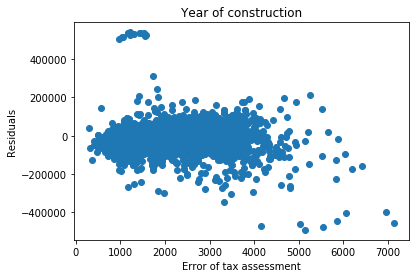

In [106]:
y_test = y_test.reshape(len(y_test),)
residuals = y_test - y_hat

#print(residuals.shape)
#print(y_test.shape)
#print(scale_factor)
plt.figure()

plt.xlabel('Error of tax assessment')
plt.ylabel('Residuals')
plt.title('Year of construction')
X_axis = X_test[:,9]
y_axis = residuals
plt.scatter(X_axis, y_axis)

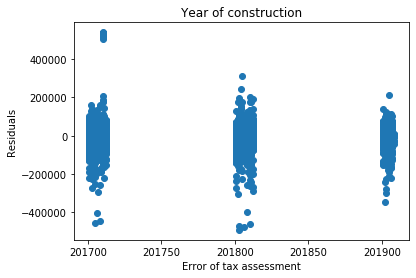

In [107]:
y_test = y_test.reshape(len(y_test),)
residuals = y_test - y_hat

#print(residuals.shape)
#print(y_test.shape)
#print(scale_factor)
plt.figure()

plt.xlabel('Error of tax assessment')
plt.ylabel('Residuals')
plt.title('Year of construction')
X_axis = X_test[:,0]
y_axis = residuals
plt.scatter(X_axis, y_axis)

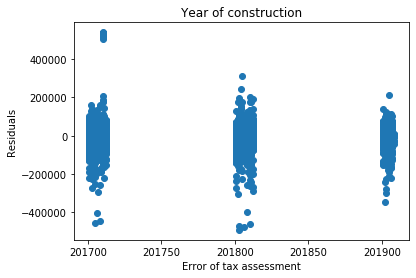

In [108]:
plt.figure()

plt.xlabel('Error of tax assessment')
plt.ylabel('Residuals')
plt.title('Year of construction')
X_axis = X_test[:,0]
y_axis = residuals
plt.scatter(X_axis, y_axis)

In [112]:
print("Mean diff is:" + str(np.median(y_test)))
print("Mean house is is:" + str(np.median(X_test[:,1])))

print(np.median(y_test) / np.median(X_test[:,1]))

Mean diff is:152909061510.66672
Mean house is is:210000.0
728138.388146032


In [110]:
print((data['TaxEval']).median())
print((data['SalePrice']).median())

176805.66666666666
210000.0
